In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np

import common

In [4]:
date_set_path = "../temp_sets_100/"

# Chartevents

## Read samples

In [5]:
chartevents_df = common.read_csv_no_rowid(date_set_path + "chartevents.csv")

## Data preproces

In [6]:
# Drop useless colums
chartevents_df.drop(['subject_id', 'hadm_id', 'cgid', 'valuenum', 'valueuom', 'warning', 'error', 'resultstatus', 'stopped'], axis=1, inplace=True)

### Process null values

In [7]:
# Drop some null value
chartevents_df.dropna(subset=['icustay_id'], inplace=True, axis=0)

In [8]:
common.nan_count(chartevents_df)

Total columns: 5
Total rows: 674770
--------------
icustay_id       0
itemid           0
charttime        0
storetime        0
value         3595
dtype: int64


In [9]:
chartevents_df['value'].fillna(value='Na', inplace=True)

### Set the column types

In [10]:
chartevents_df.dtypes

icustay_id    float64
itemid          int64
charttime      object
storetime      object
value          object
dtype: object

In [11]:
# Transfer some date type
# chartevents_df['subject_id'] = chartevents_df['subject_id'].astype(str)
# chartevents_df['hadm_id'] = chartevents_df['hadm_id'].astype(str)
# chartevents_df['icustay_id'] = chartevents_df['icustay_id'].astype(str)

# chartevents_df['itemid'] = chartevents_df['itemid'].astype(str)

chartevents_df['charttime'] = pd.to_datetime(chartevents_df['charttime'])
chartevents_df['storetime'] = pd.to_datetime(chartevents_df['storetime'])

In [12]:
chartevents_df.dtypes

icustay_id           float64
itemid                 int64
charttime     datetime64[ns]
storetime     datetime64[ns]
value                 object
dtype: object

### Process time value

In [13]:
icustays_df = common.read_csv_no_rowid(date_set_path+"icustays.csv")

In [14]:
icu_intime_df = icustays_df.loc[:, ['icustay_id', 'intime']]
icu_intime_df['intime'] = pd.to_datetime(icu_intime_df['intime'])

In [15]:
chartevents_mid_df = pd.merge(left=chartevents_df, right=icu_intime_df, how='left', on=['icustay_id'])

In [16]:
chartevents_mid_df.dtypes

icustay_id           float64
itemid                 int64
charttime     datetime64[ns]
storetime     datetime64[ns]
value                 object
intime        datetime64[ns]
dtype: object

In [17]:
chartevents_mid_df['storetime'] = chartevents_mid_df.apply(common.time_process, args=('charttime', 'storetime'), axis=1)
chartevents_mid_df['charttime'] = chartevents_mid_df.apply(common.time_process, args=('intime', 'charttime'), axis=1)

In [18]:
chartevents_mid_df

,icustay_id,itemid,charttime,storetime,value,intime
0,271533.0,644,91600.0,780.0,Intact,2105-02-21 13:33:20
1,271533.0,550,91600.0,780.0,Universal,2105-02-21 13:33:20
2,271533.0,581,91600.0,780.0,88.5,2105-02-21 13:33:20
3,271533.0,593,91600.0,780.0,Diminished,2105-02-21 13:33:20
4,271533.0,599,91600.0,780.0,Clear,2105-02-21 13:33:20
...,...,...,...,...,...,...
674765,237653.0,157,32961.0,720.0,24cm,2107-12-06 18:50:39
674766,237653.0,200,32961.0,6780.0,Salem Sump,2107-12-06 18:50:39
674767,237653.0,203,32961.0,6780.0,Low Cont Suction,2107-12-06 18:50:39
674768,237653.0,156,90561.0,4260.0,Easily Palpable,2107-12-06 18:50:39


In [19]:
chartevents_df = chartevents_mid_df.drop(['icustay_id', 'intime'], axis=1)

##  Build Network

---

### CTGAN

In [20]:
from sdv.tabular import CTGAN
from sdv.evaluation import evaluate
from sdv.constraints import FixedCombinations

In [21]:
fixed_item_value_constraint = FixedCombinations(
    column_names=['itemid', 'value']
)

In [22]:
chartevents_constraints = [fixed_item_value_constraint]

In [23]:
model = CTGAN(
    constraints=chartevents_constraints, 
    cuda=True, 
    verbose=True)

In [24]:
len(chartevents_df)

674770

In [25]:
train_data = chartevents_df.sample(n=2000)
model.fit(train_data)

Epoch 1, Loss G:  7.1333,Loss D: -0.0131
Epoch 2, Loss G:  7.1307,Loss D: -0.0267
Epoch 3, Loss G:  7.0787,Loss D: -0.0247
Epoch 4, Loss G:  7.0573,Loss D: -0.0325
Epoch 5, Loss G:  7.0222,Loss D:  0.0017
Epoch 6, Loss G:  6.9824,Loss D:  0.0092
Epoch 7, Loss G:  7.0099,Loss D: -0.0002
Epoch 8, Loss G:  6.9619,Loss D:  0.0117
Epoch 9, Loss G:  6.9544,Loss D:  0.0362
Epoch 10, Loss G:  6.9114,Loss D:  0.0466
Epoch 11, Loss G:  6.9243,Loss D:  0.0046
Epoch 12, Loss G:  6.9769,Loss D: -0.0143
Epoch 13, Loss G:  6.9721,Loss D: -0.0239
Epoch 14, Loss G:  6.9945,Loss D: -0.0282
Epoch 15, Loss G:  6.9342,Loss D:  0.0135
Epoch 16, Loss G:  6.9294,Loss D:  0.0399
Epoch 17, Loss G:  6.9338,Loss D: -0.0003
Epoch 18, Loss G:  6.9339,Loss D:  0.0019
Epoch 19, Loss G:  6.9556,Loss D:  0.0032
Epoch 20, Loss G:  6.8840,Loss D:  0.0130
Epoch 21, Loss G:  6.8554,Loss D:  0.0265
Epoch 22, Loss G:  6.8315,Loss D:  0.0261
Epoch 23, Loss G:  6.8524,Loss D: -0.0004
Epoch 24, Loss G:  6.8638,Loss D: -0.0257
E

In [26]:
# model.save(date_set_path + "100_models/" + "chartevents_model.pkl")

import cloudpickle

with open(date_set_path + "100_models/" + "chartevents_model.pkl", 'wb') as f:
    cloudpickle.dump(model, f)

In [50]:
sample = model.sample(num_rows=10000)

Sampling rows: 100%|██████████| 10000/10000 [00:00<00:00, 18255.73it/s]


In [51]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False

In [52]:
def format_values(df):
    if is_number(df['value']):
        return round(float(df['value']), 2)
    else:
        return df['value']


In [53]:
sample['value'] = sample.apply(format_values, axis=1)
sample['value'] = sample['value'].astype(str)

In [54]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.9164529749993492

In [55]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

nan

In [56]:
evaluate(sample, train_data)

0.47905588271043614

<AxesSubplot:>

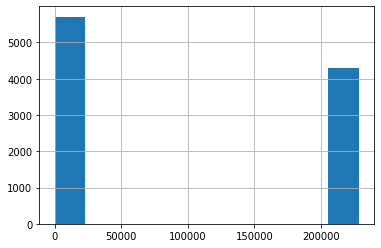

In [32]:
sample.sort_values('itemid')['itemid'].hist()

<AxesSubplot:>

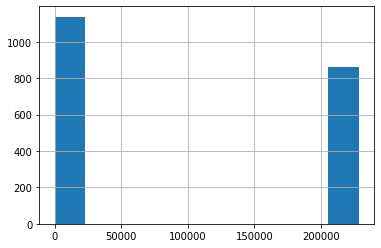

In [33]:
train_data.sort_values('itemid')['itemid'].hist()